The research of factors affecting the rate of university enrollment in a certain region

I want to find the factors affecting the rate of university enrollment in certain regions of Victoria. These factors may include average income in this region, average education level and so on.
I used 5 years data of students' destination after yr12 to find a region's average rate of university enrollment in 5 years.
(yr2017,2016,2014,2013,2012 and I did not find the data of year 2015). And in order to find that factors, I merged these data with lga profile by lga name.

Ruoyu Wu 947132 (09/05/2018)

In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns


from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist, squareform


In [2]:
#prepared function
def VAT(R):
          
    R = np.array(R)
    N, M = R.shape
    if N != M:
        R = squareform(pdist(R))
        
    J = list(range(0, N))
    
    y = np.max(R, axis=0)
    i = np.argmax(R, axis=0)
    j = np.argmax(y)
    y = np.max(y)


    I = i[j]
    del J[I]

    y = np.min(R[I,J], axis=0)
    j = np.argmin(R[I,J], axis=0)
    
    I = [I, J[j]]
    J = [e for e in J if e != J[j]]
    
    C = [1,1]
    for r in range(2, N-1):   
        y = np.min(R[I,:][:,J], axis=0)
        i = np.argmin(R[I,:][:,J], axis=0)
        j = np.argmin(y)        
        y = np.min(y)      
        I.extend([J[j]])
        J = [e for e in J if e != J[j]]
        C.extend([i[j]])
    
    y = np.min(R[I,:][:,J], axis=0)
    i = np.argmin(R[I,:][:,J], axis=0)
    
    I.extend(J)
    C.extend(i)
    
    RI = list(range(N))
    for idx, val in enumerate(I):
        RI[val] = idx

    RV = R[I,:][:,I]
    
    return RV.tolist(), C, I

#as the columns name in different dataset have some tiny difference.
def f_destcol(df):
    if "DESTINATION" in df.columns:
        return 1
    elif "DESTINATION " in df.columns:
        return 2

#check the destinations of dataframe
def f_dst(df):
    if f_destcol(df) == 1:
        dest = y2017_df['DESTINATION']
    elif f_destcol(df) == 2:
        dest = y2017_df['DESTINATION ']
    dst = []
    for i in dest:
        if not i in dst:
            dst.append(i)
    dst.sort()
    return dst

#if there is any difference between two columns from two dataframe
def difflga(col1,col2):
    lga = []
    out = []
    for i in col1:
        if i not in lga:
            lga.append(i)
    for x in col2:
        if x not in lga:
            out.append(x)
    return(out)

#change destination into num and help us to calculate the rate of university enrollment
def desttonum(dest):
    if (dest == 'Bachelor degree'):
        return 4
    elif (dest == 'Apprenticeship/traineeship') or (dest == 'Certificates/diplomas'):
        return 3
    elif (dest == 'Apprenticeship') or (dest == 'Certificate I-III'):
        return 3
    elif (dest == 'Certificate IV or higher') or (dest == 'Traineeship'):
        return 3
    elif (dest == 'Employed'):
        return 2
    elif (dest == 'Employed full-time') or (dest == 'Employed part-time'):
        return 2
    elif (dest == 'Looking for work') or (dest == 'NILFET'):
        return 1
    elif (dest == 'Unknown'):
        return 0

#find the enrolling rate of each area in certain year
def bachldegr(df):
    perct =[]
    if f_destcol(df) == 1:
        df['dest'] = df["DESTINATION"].map(desttonum)
    elif f_destcol(df) == 2:
        df['dest'] = df["DESTINATION "].map(desttonum)
    df = df[df['dest']>=1]
    grouped = df.groupby(['LOCAL GOVERNMENT AREA'])
    for i in re_lga:
        size = grouped.get_group(i).shape[0]
        area = grouped.get_group(i)
        n = 0 
        for i in area['dest']:
            if i==4:
                n+=1
        p = round(n/size,4)
        perct.append(round(100*p,4))
    return perct

#translate metropolitan into numbers
def metro_or_not(df):
    perct=[]
    grouped = df.groupby(['LOCAL GOVERNMENT AREA'])
    for i in re_lga:
        size = grouped.get_group(i).shape[0]
        area = grouped.get_group(i)
        n = 0 
        for i in area['METRO/NON-METRO']:
            if i=="Metropolitan":
                n+=1
        p = round(n/size,4)
        if p == 1:
            perct.append(1)
        elif p == 0:
            perct.append(0)
        else:
            return False
    return perct

#since the lga profile has a mass of columns, we need to find out the useable ones
def search_col(keyword):
    cols =[]
    for i in lga_df.columns:
        if keyword in i:
            cols.append(i)
    return cols

#fill the missing data in the whole dataframe
def myfillna(df):
    cols = df.columns
    for i in cols:
        mean = round(df[i].mean(),2)
        df[i][df[i].isnull()] = mean
    return df

In [3]:
#lga data
lga_df = pd.read_csv("data2534206941284483101.csv", index_col = " id")
names = lga_df[" lga_name"]
propt = lga_df.columns
re_names= []
#remove the (C),(RC)s in lga name, to help merge the dataframes
for i in names:
    a = re.sub(u"\\(.*?\\)", "", i).strip()
    re_names.append(a)
lga_df['lga'] = re_names

In [4]:
y2017_df = pd.read_csv("dv260-ontrackyear122017.csv",index_col = "STUDENT_ID")
y2016_df = pd.read_csv("dv239-onorackoyear12orequivcomp2016.csv", index_col="STUDENT ID")
y2014_df = pd.read_csv("dv121ontrackyr 12orequivalentcompleters2014.csv", index_col="STUDENT ID")
y2013_df = pd.read_csv("dv164-ontrackyear12orequivcompleters2013.csv",index_col="STUDENT ID")
y2012_df = pd.read_csv("dv163-ontrackyear12orequivcompleters2012.csv",index_col="STUDENT ID")

In [5]:
#print(difflga(y2017_df['LOCAL GOVERNMENT AREA'],re_names))
#print(difflga(y2016_df['LOCAL GOVERNMENT AREA'],re_names))
#print(difflga(y2014_df['LOCAL GOVERNMENT AREA'],re_names))
#print(difflga(y2013_df['LOCAL GOVERNMENT AREA'],re_names))
#print(difflga(y2012_df['LOCAL GOVERNMENT AREA'],re_names))
#we can see that in lga dataset there are two area, Golden Plains and Queenscliffe,
#which do not have destination statistics, so we need to drop the corresponding rows in lga_df

#print("attributes of y2017_df: ",y2017_df.columns)
#print("attributes of y2016_df: ",y2016_df.columns)
#print("attributes of y2014_df: ",y2014_df.columns)
#print("attributes of y2013_df: ",y2013_df.columns)
#print("attributes of y2012_df: ",y2012_df.columns)

#dst = f_dst(y2017_df)
#dst1 = f_dst(y2016_df)
#dst2 = f_dst(y2014_df)
#dst3= f_dst(y2013_df)
#dst4= f_dst(y2012_df)

#print("dst:",dst)
#print("dst1:",dst1)
#print("dst2:",dst2)
#print("dst3:",dst3)
#print("dst4:",dst4)
#print(y2017_df['METRO/NON-METRO'])

In [6]:
lga_df=lga_df[lga_df['lga'] != 'Golden Plains']
lga_df=lga_df[lga_df['lga'] != 'Queenscliffe']
re_lga=lga_df['lga']

wranking data

In [7]:
#find the useable columns
yr_12=search_col('yr_12')
fertility_rate = search_col('fertility_rate')
drug=search_col('drug')
safe=search_col('safe')
offence=search_col('offen')
headed_by_one=search_col('headed_by_one')
income=search_col('income')
    #low_income_families_with_chn_perc 
    #ppl_with_income_less_aud400_per_week_perc  Percentage of individuals with income less than AUD400 per week (2011)
homeless=search_col('homeless')
full_time_equivalent=search_col("full_time_equivalent")
rental=search_col("rental")
higher_edu_qual=search_col('higher_edu_qual')
public_school=search_col('public_school')
student=search_col('student')
    #yr_9_students_attaining_nat_min_numeracy_std_perc
    #   Percentage of Year 9 students attaining national minimum numeracy standards (2014)
    #yr_9_students_attaining_nat_min_numeracy_std_rank
    #    Year 9 students attaining national minimum numeracy standards (rank) (2014)
employ=search_col('employ')

In [8]:
#find the enrolling rate in each year
if metro_or_not(y2017_df): 
    lga_df['metro_or_not'] = metro_or_not(y2017_df)
lga_df["bachalor_in_2017(%)"]=bachldegr(y2017_df)
lga_df["bachelor_in_2016(%)"]=bachldegr(y2016_df)
lga_df["bachelor_in_2014(%)"]=bachldegr(y2014_df)
lga_df["bachelor_in_2013(%)"]=bachldegr(y2013_df)
lga_df["bachelor_in_2012(%)"]=bachldegr(y2012_df)
lga_df["aver_bachelor(%)"]=(lga_df["bachalor_in_2017(%)"]+lga_df["bachelor_in_2016(%)"]+lga_df["bachelor_in_2014(%)"]\
                                                  +lga_df["bachelor_in_2013(%)"]+lga_df["bachelor_in_2012(%)"])/5


In [9]:
cols=list(set(fertility_rate+drug+safe+offence\
              +employ+income+rental+homeless+headed_by_one\
              +yr_12+full_time_equivalent+public_school+student\
              +higher_edu_qual))

cols_p=sorted(cols)
for i in cols_p:
    if ("rank" in i):
        cols.remove(i)
cols.append('lga')
cols.append('metro_or_not')
cols.append("aver_bachelor(%)")

draw plots

<function matplotlib.pyplot.show(*args, **kw)>

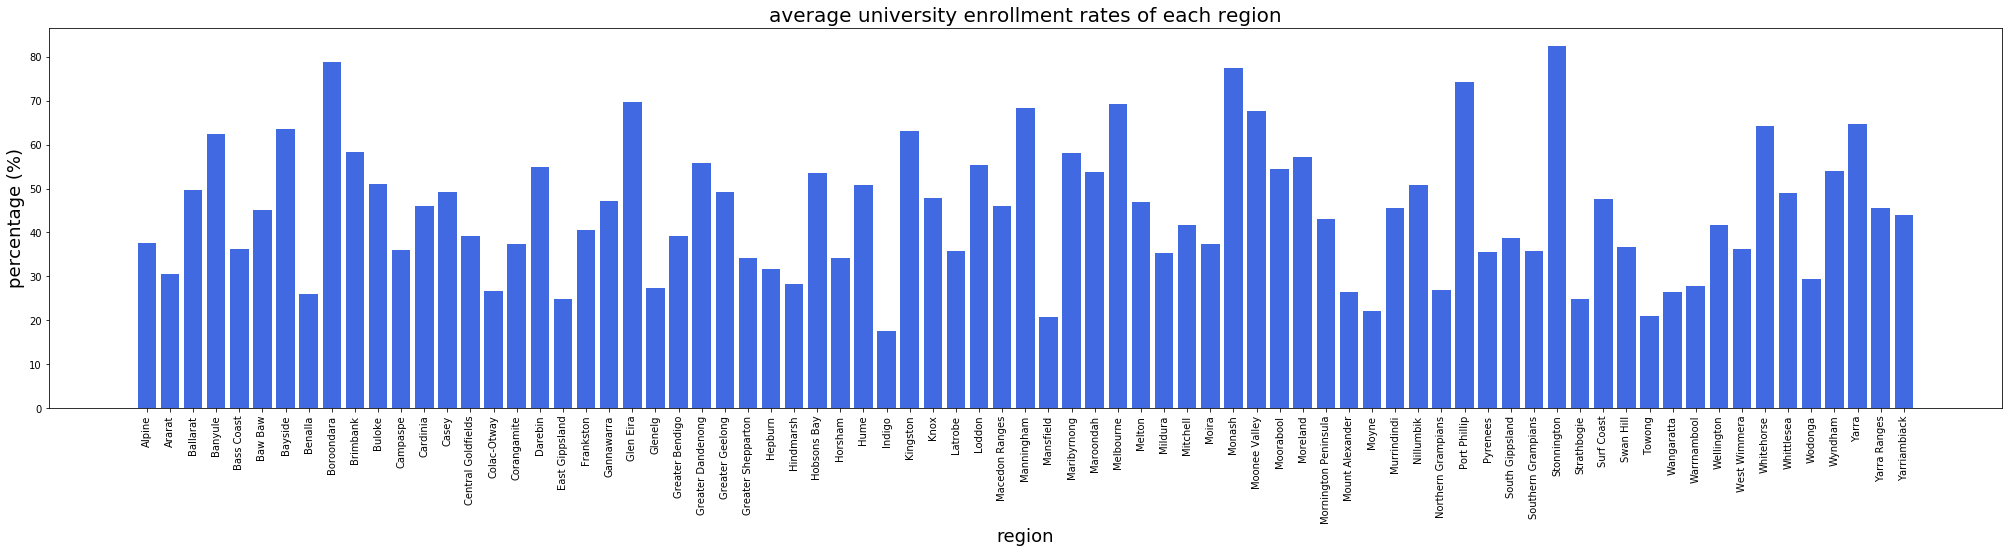

In [20]:
plt.bar(range(77), lga_df['aver_bachelor(%)'],color= 'royalblue')
plt.xticks(range(77),re_lga,rotation=90)
plt.rcParams['figure.figsize'] =(35,7)
plt.title('average university enrollment rates of each region',size=20)
plt.ylabel('percentage (%)',fontsize=18)
plt.xlabel('region',fontsize=18)
plt.savefig('bar_metro_orig.png')
plt.show

In [21]:
new_df = lga_df.loc[:,cols]
reindx_df=new_df.set_index("lga")
teenage_fertility_rate_mean = round(reindx_df[' teenage_fertility_rate'].mean(),2)
reindx_df[' teenage_fertility_rate'][reindx_df[' teenage_fertility_rate'].isnull()] = teenage_fertility_rate_mean

C:\Users\Roywr\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


<function matplotlib.pyplot.show(*args, **kw)>

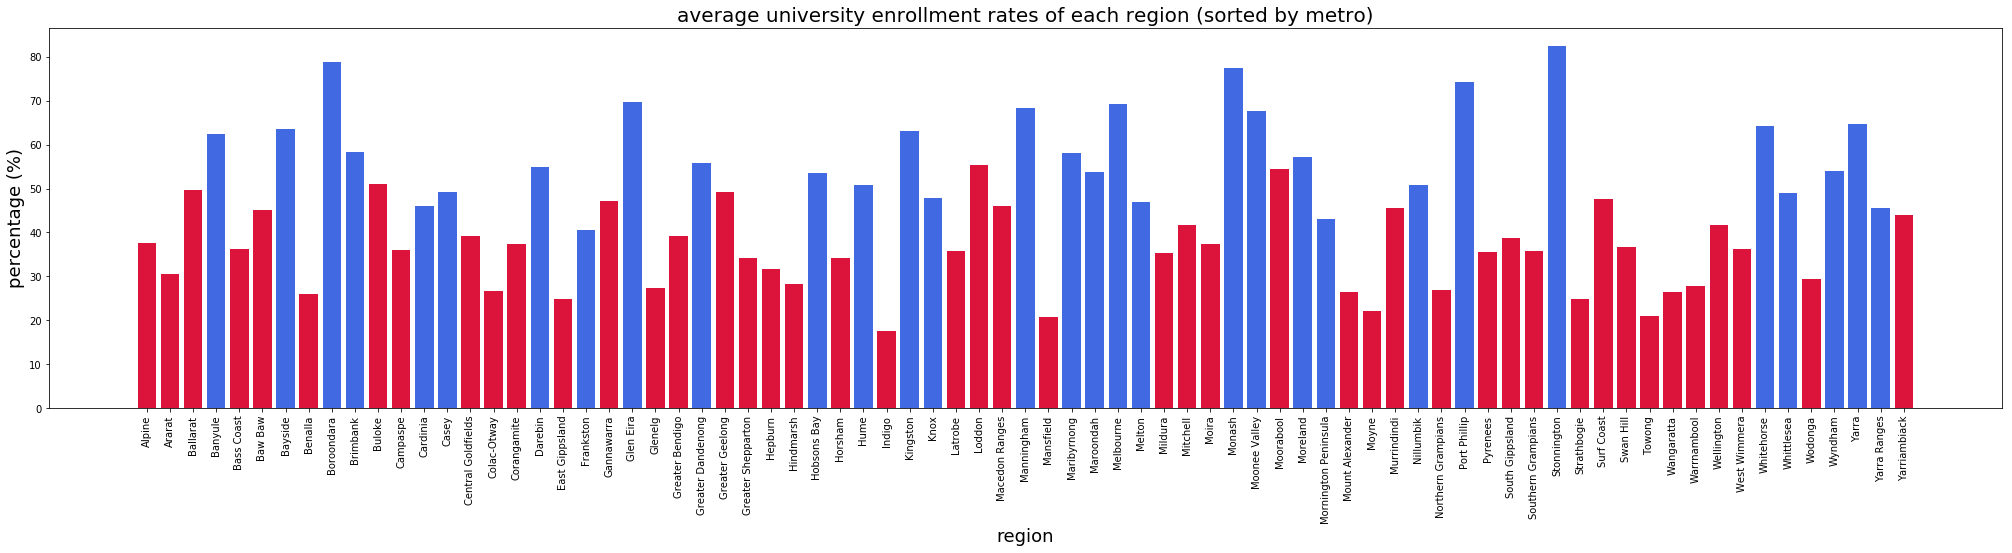

In [22]:
# color suburb area with red, while color urban area with blue
c =['crimson','royalblue']
colors = reindx_df.metro_or_not.replace(to_replace=reindx_df.metro_or_not.unique(),value=c).tolist()
plt.bar(range(77), lga_df['aver_bachelor(%)'],color=colors)
plt.xticks(range(77),re_lga,rotation=90)
plt.title('average university enrollment rates of each region (sorted by metro)',size=20)
plt.ylabel('percentage (%)',fontsize=18)
plt.xlabel('region',fontsize=18)
plt.rcParams['figure.figsize'] =(35,7)
plt.savefig('bar_metro.png')
plt.show


<function matplotlib.pyplot.show(*args, **kw)>

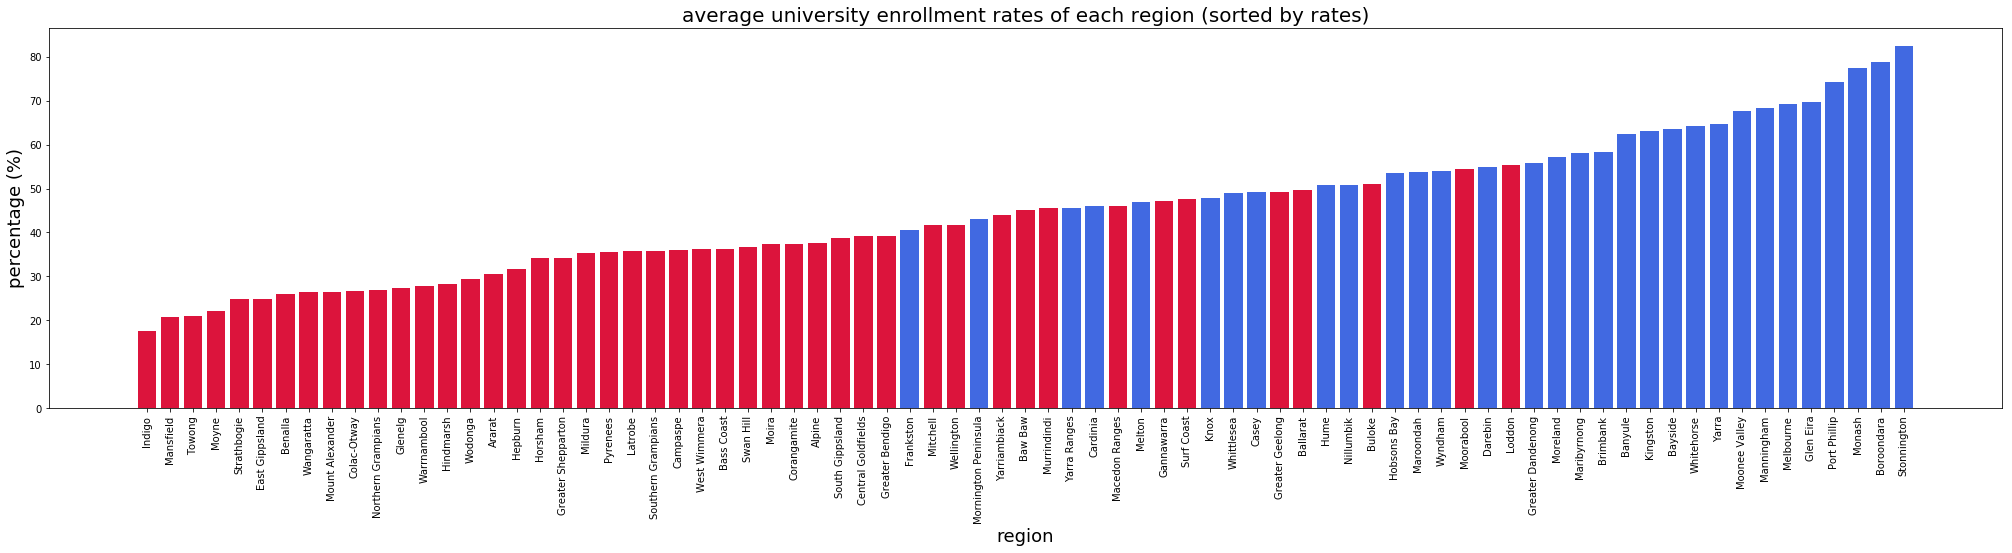

In [23]:
sortedmetro_df = lga_df.loc[:, ['aver_bachelor(%)','lga','metro_or_not']]
sm_df = sortedmetro_df.set_index('lga',drop=False)
ssm_df = sm_df.sort_values('aver_bachelor(%)')
colors1= ssm_df.metro_or_not.replace(to_replace=ssm_df.metro_or_not.unique(),value=c).tolist()
plt.bar(range(77), ssm_df['aver_bachelor(%)'],color=colors1)
plt.xticks(range(77),ssm_df['lga'],rotation=90)
plt.title('average university enrollment rates of each region (sorted by rates)',size=20)
plt.ylabel('percentage (%)',fontsize=18)
plt.xlabel('region',fontsize=18)
plt.rcParams['figure.figsize'] =(35,7)
plt.savefig('bar_metro_s.png')
plt.show


In [14]:
X=reindx_df.drop(['metro_or_not'],axis=1)
X=myfillna(X)# fill the missing values
y = reindx_df['metro_or_not']

scaler = StandardScaler()
scaler.fit(X)

#normalization
X_scaled = scaler.transform(X)

#second try

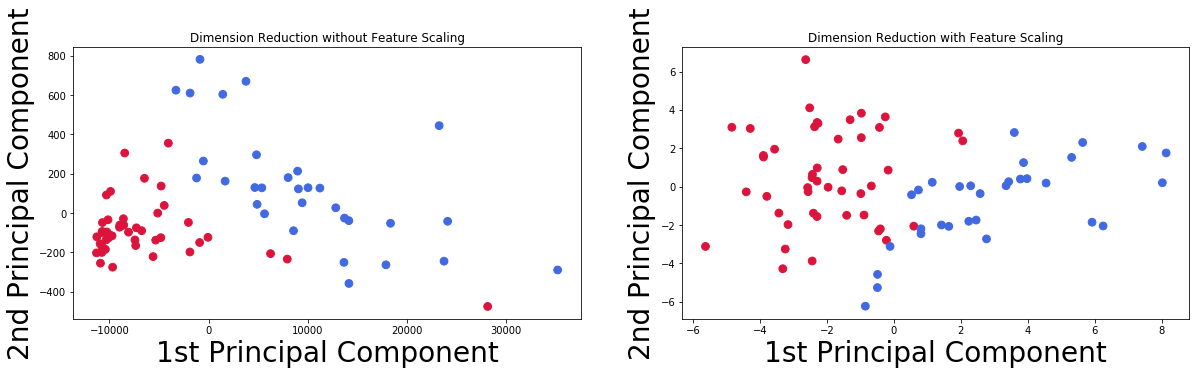

In [24]:
#Principal Component Analysis
sklearn_pca = PCA(n_components=2)   #the first two PCs
X_reduced= sklearn_pca.fit_transform(X)
X_redc2 = sklearn_pca.fit_transform(X_scaled)

plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.scatter(X_reduced[:,0],X_reduced[:,1],s=60,c=colors)   #plot the PC's in 2D - s marker size
plt.xlabel('1st Principal Component', fontsize=28)
plt.ylabel('2nd Principal Component', fontsize=28)
plt.title("Dimension Reduction without Feature Scaling")
plt.subplot(1,2,2)
plt.scatter(X_redc2[:,0],X_redc2[:,1],s=60,c=colors)   #plot the PC's in 2D - s marker size
plt.xlabel('1st Principal Component', fontsize=28)
plt.ylabel('2nd Principal Component', fontsize=28)
plt.title("Dimension Reduction with Feature Scaling")
plt.savefig('PCA.png')
plt.show()


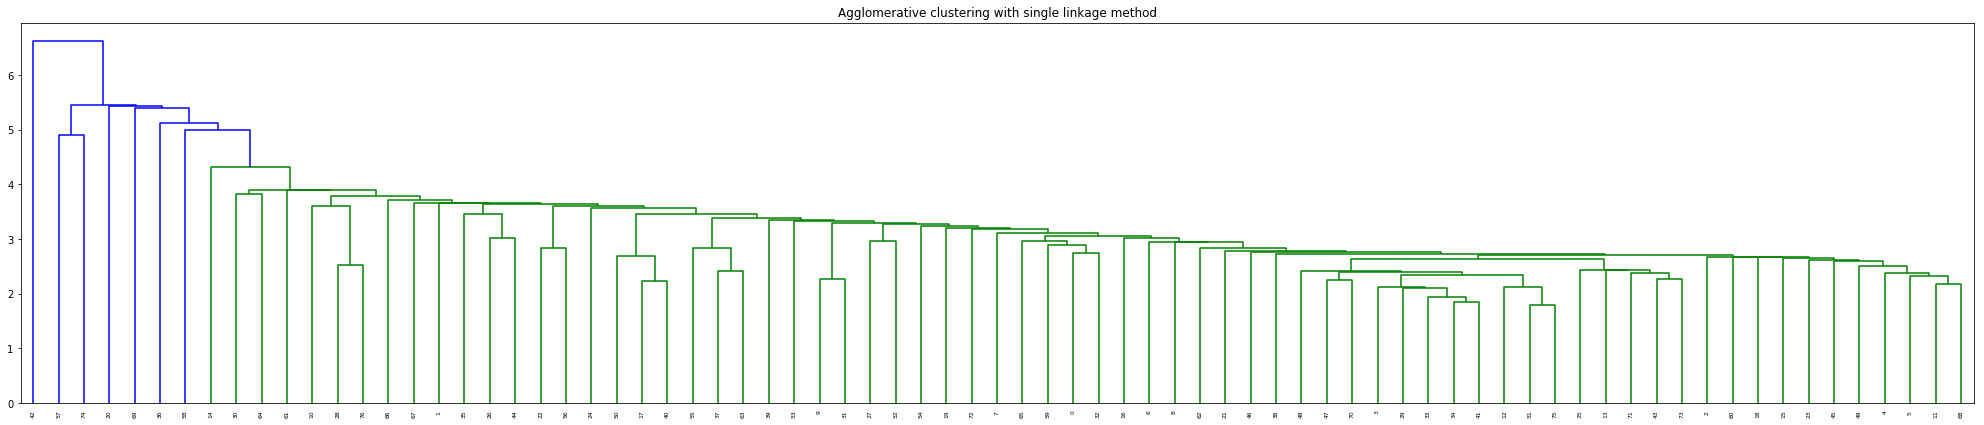

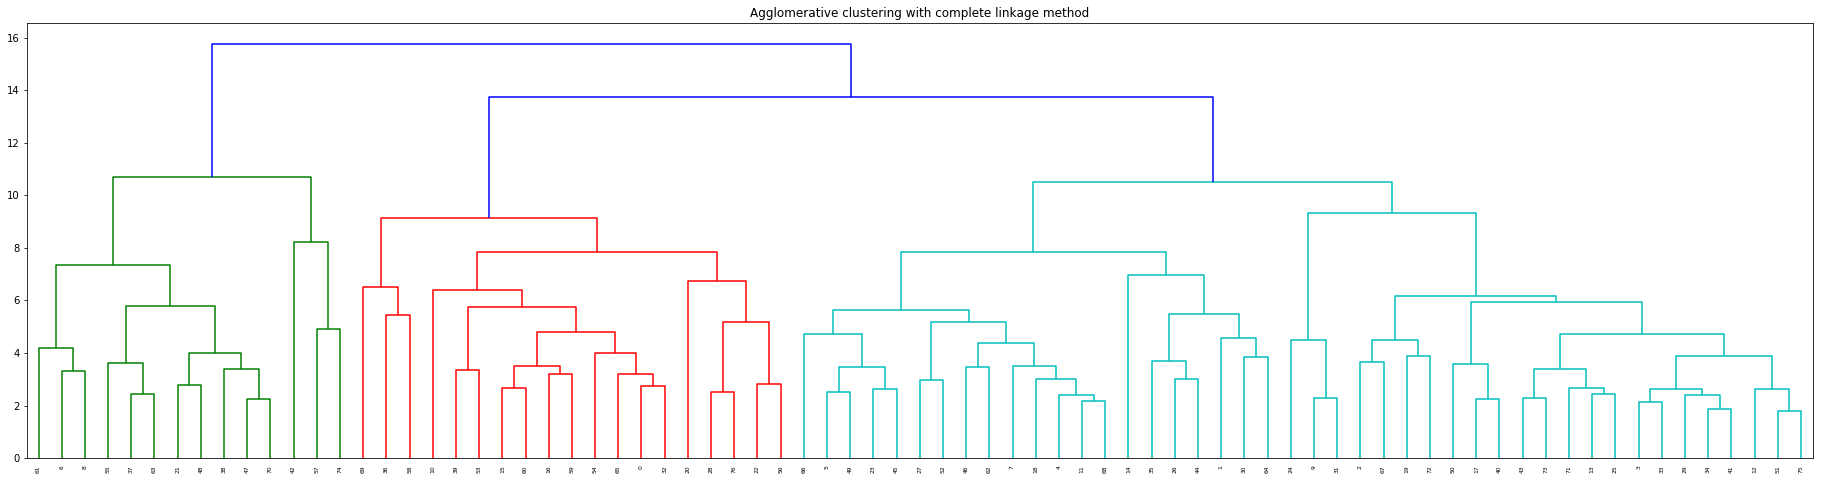

In [25]:
#Hierarchical Clustering
#single linkage
hc1 = linkage(X_scaled, 'single') 
dendrogram(hc1)
plt.title("Agglomerative clustering with single linkage method")
plt.rcParams['figure.figsize'] =(32,8)
plt.show()

#complete linkage
hc2 = linkage(X_scaled, 'complete') # 
dendrogram(hc2)
plt.title("Agglomerative clustering with complete linkage method")
plt.rcParams['figure.figsize'] =(32,8)
plt.savefig('cluster.png')
plt.show()


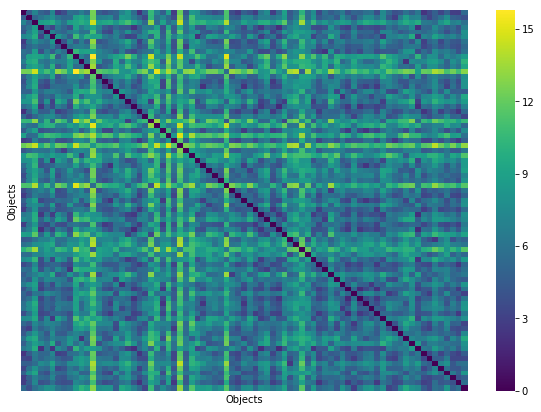

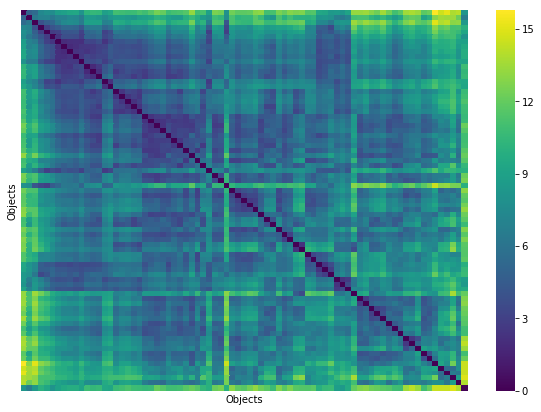

In [27]:

X_cpy = X_scaled.copy()
np.random.shuffle(X_cpy)

sq = squareform(pdist(X_cpy))
ax=sns.heatmap(sq,cmap='viridis',xticklabels=False,yticklabels=False)
ax.set(xlabel='Objects', ylabel='Objects')
plt.rcParams['figure.figsize'] =(10,7)
plt.savefig('heatmap1.png')
plt.show()

RV,C,I=VAT(X_scaled)
x=sns.heatmap(RV,cmap='viridis',xticklabels=False,yticklabels=False)
x.set(xlabel='Objects', ylabel='Objects')
plt.rcParams['figure.figsize'] =(10,7)
plt.savefig('heatmap2.png')
plt.show()



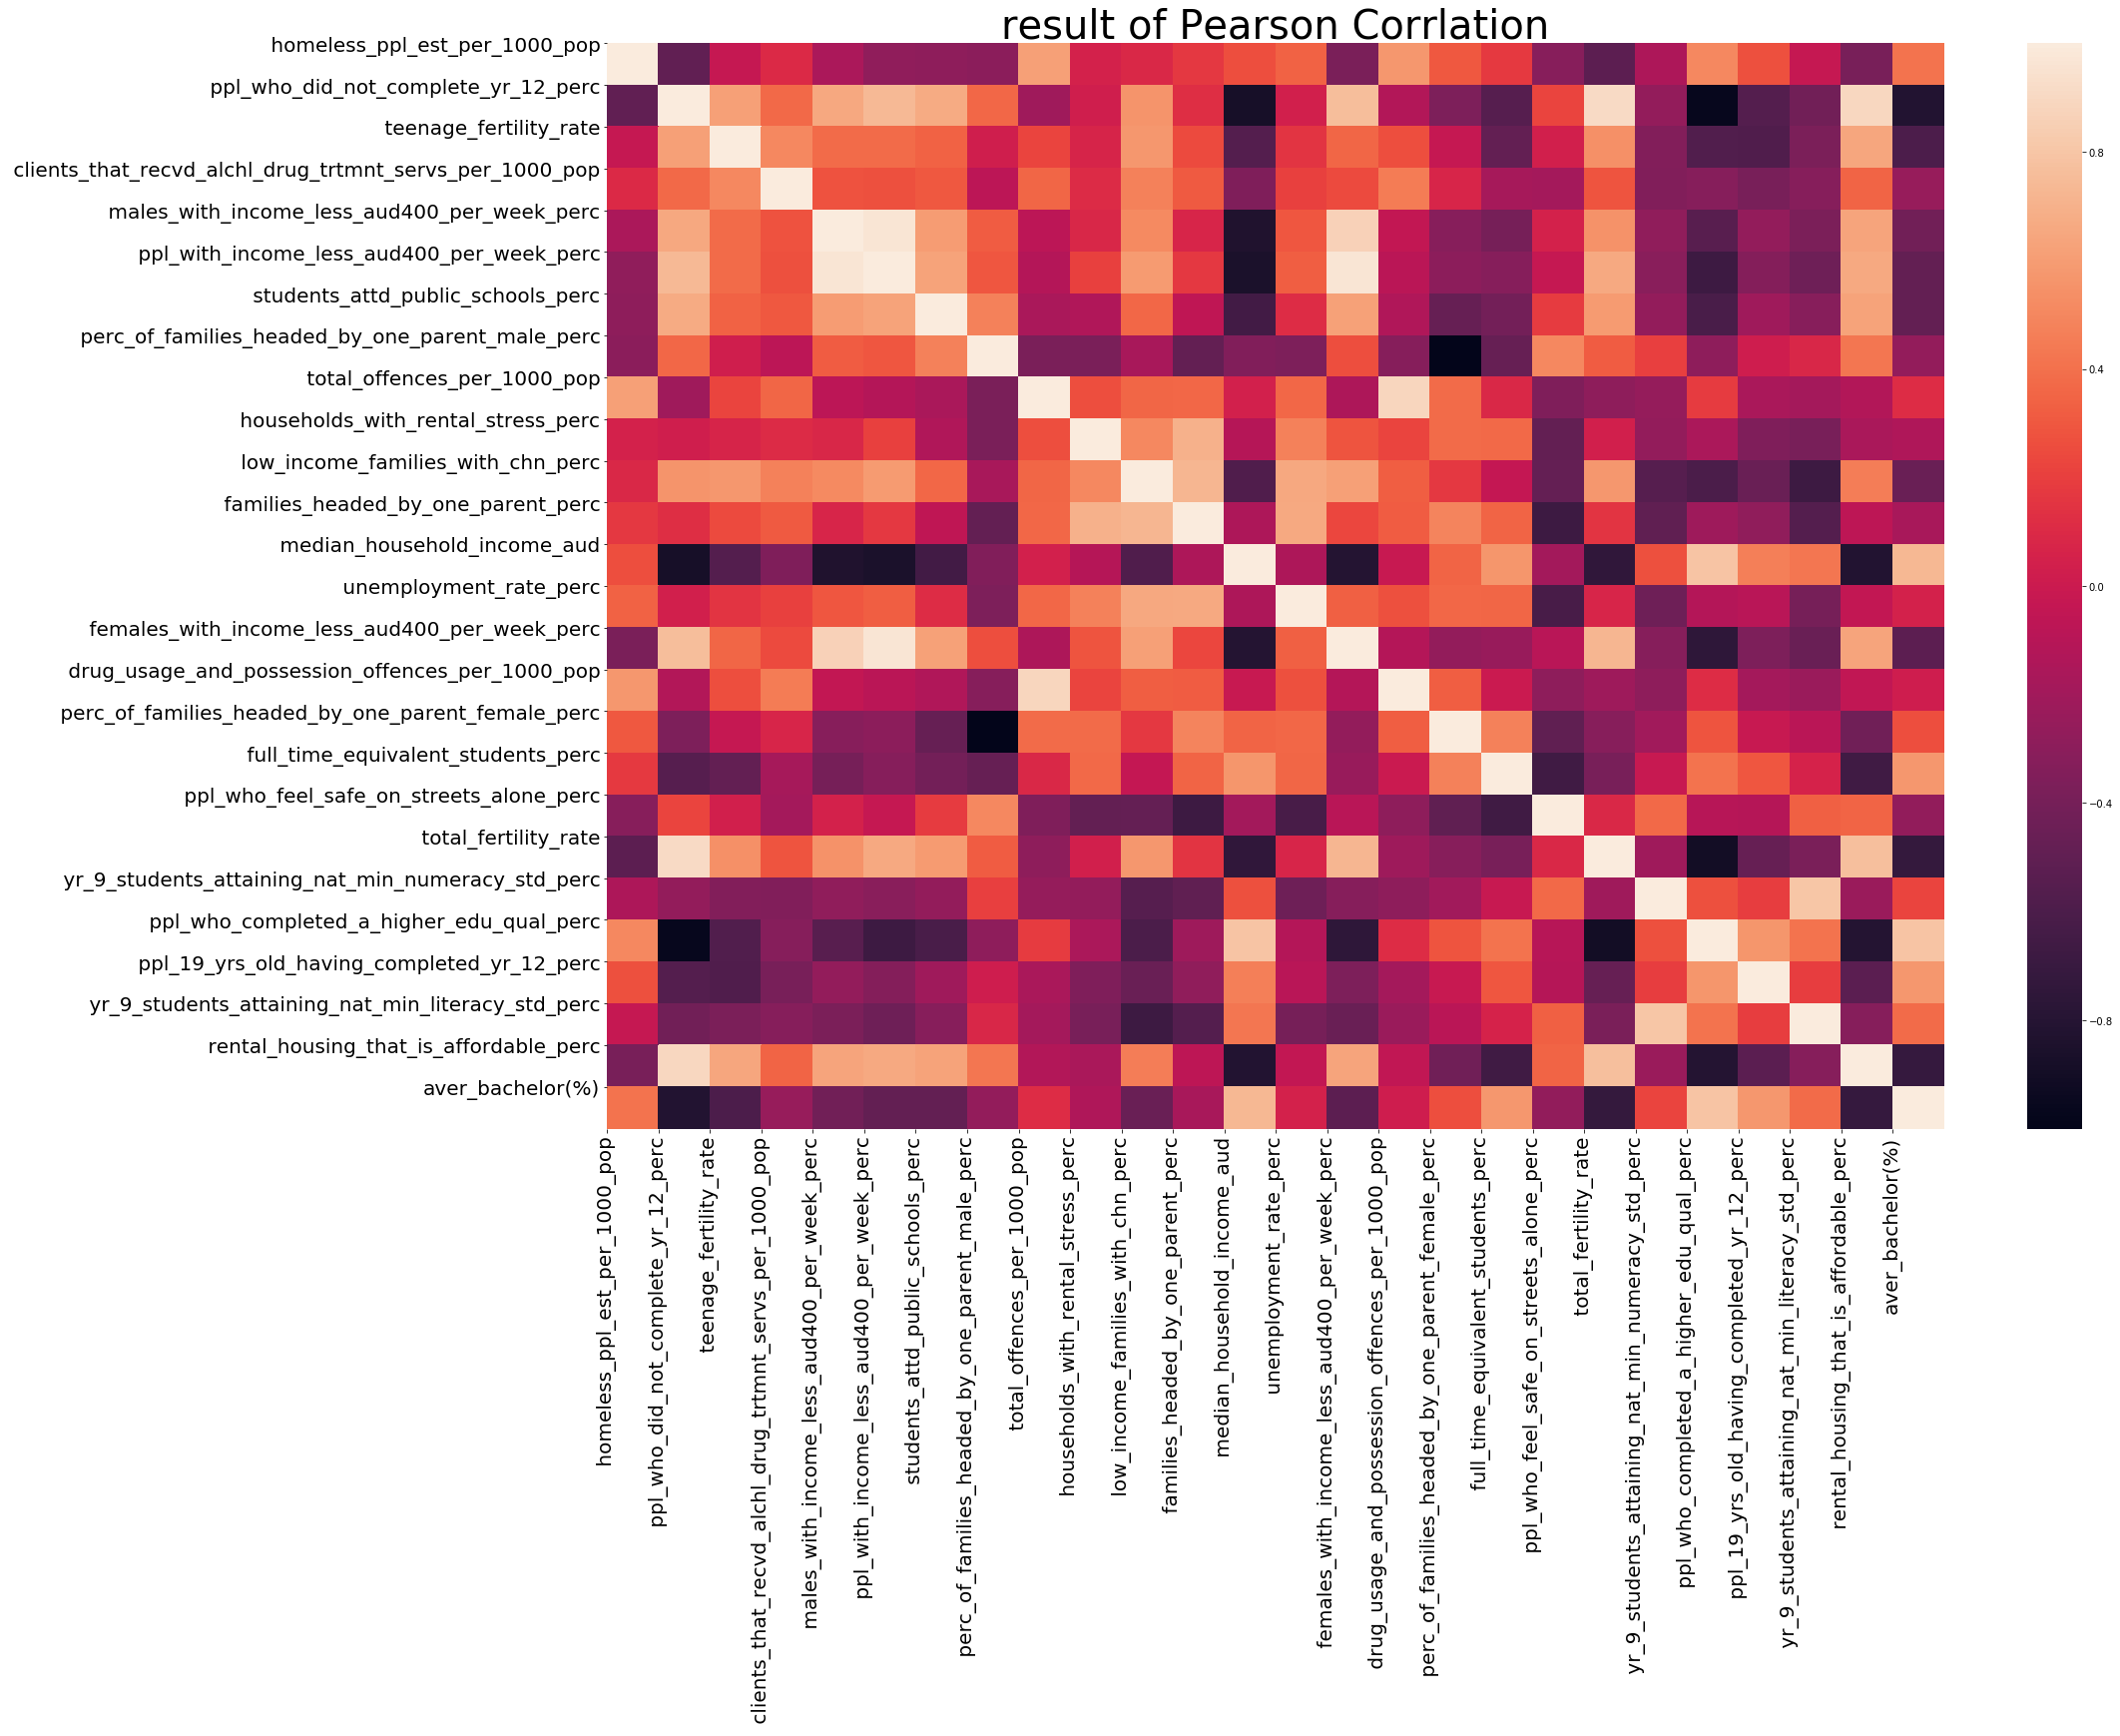

In [33]:
#Pearson Correlation
scaled_df = pd.DataFrame(X_scaled)
corr = scaled_df.corr()#pearson correlation

sns.heatmap(corr,xticklabels=False,yticklabels=False )
plt.xticks(range(len(corr.columns)),X.columns,rotation=90,fontsize =20)
plt.yticks(range(len(corr.columns)),X.columns,fontsize=20)
plt.rcParams['figure.figsize'] =(30,20)
plt.title('result of Pearson Corrlation',size=40)
plt.savefig('heatmap3.png')
plt.show()


In the bar chart, we can easily find that the urban area have a higher college enrolling rate than the suburb. And the regions with highest rate are all the urban area, while the regions with lost rate are in the suburb. This shows us that if the region in the urban area has a strong correlationship with rate of university enrollment. 
After analysing the other plots, we can find that the factors like the median household income, teenage fertility rate, higher education qualification completing rate also have a significant influence.
In these data processing, the data cleaning is my hardest challenges. Because using several dataset, there are many column names I have to unify. Beyond that, it took me plenty of time to search for useable columns in lga profile.

Reference:

for year 2017
source: Post school destinations of Year 12 or equivalent completers, Victorian schools, 2017
url: http://www.education.vic.gov.au/Documents/about/research/datavic/dv260-ontrackyear122017.csv
for year 2016
source: 2016 On Track Year 12 or equivalent completers student level destination data
url: http://www.education.vic.gov.au/Documents/about/research/datavic/dv239-onorackoyear12orequivcomp2016.csv
for year 2014
source: 2014 On Track Year 12 or equivalent completers student level destination data
url: http://www.education.vic.gov.au/Documents/about/research/datavic/dv121ontrackyr%2012orequivalentcompleters2014.csv
for year 2013
source: 2013 On Track - Individual Year 12 Student Completers
url: http://www.education.vic.gov.au/Documents/about/research/datavic/dv164-ontrackyear12orequivcompleters2013.csv
for year 2012
source: 2012 On Track - Individual Year 12 Student Completers
url: http://www.education.vic.gov.au/Documents/about/research/datavic/dv163-ontrackyear12orequivcompleters2012.csv

lga_file
source: Local Government Area (LGA) profiles data 2015 for VIC
url: https://aurin.org.au/